In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import KFold

# ### import file from another folder ###
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '../Python-Save-Plots')
# import SaveFigAsPDF_PGF as sF

Epoch:    0, Train loss: 1.06571 Test loss: 258.92633 Train RMSE: 0.37749 Test RMSE: 0.47245
Epoch:  100, Train loss: -1.19337 Test loss: -328.85349 Train RMSE: 0.06982 Test RMSE: 0.07141
Epoch:  200, Train loss: -1.29386 Test loss: -347.58875 Train RMSE: 0.06443 Test RMSE: 0.07034
Epoch:  300, Train loss: -1.36277 Test loss: -369.20682 Train RMSE: 0.06197 Test RMSE: 0.06632
Epoch:  400, Train loss: -1.35969 Test loss: -377.73511 Train RMSE: 0.06082 Test RMSE: 0.06455
Epoch:  500, Train loss: -1.42940 Test loss: -376.43350 Train RMSE: 0.05963 Test RMSE: 0.06498
Epoch:  600, Train loss: -1.44722 Test loss: -377.59814 Train RMSE: 0.05854 Test RMSE: 0.06472
Epoch:  700, Train loss: -1.45833 Test loss: -378.46387 Train RMSE: 0.05789 Test RMSE: 0.06548
Epoch:  800, Train loss: -1.48486 Test loss: -382.34613 Train RMSE: 0.05700 Test RMSE: 0.06447
Epoch:  900, Train loss: -1.49728 Test loss: -386.57703 Train RMSE: 0.05623 Test RMSE: 0.06370
Epoch: 1000, Train loss: -1.50876 Test loss: -383.03

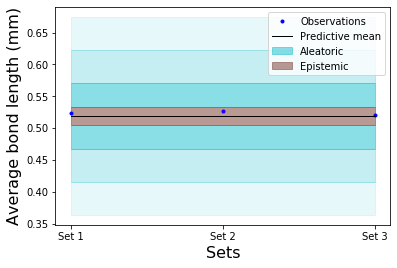

In [2]:
# Parameters
wght_decay, learn_rate = 0.1, 4e-3
train_data_ratio, nb_epochs = 0.8, 1500
p_drop_rate = 0.1
nb_units = 100
# nb_units = [10, 20, 30, 50, 100]
# p_drop_rate = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3, 0.4]

plot_history = False # plot loss and rmse vs epochs if True

def normalize_max_min(data, data_max, data_min):
    return (data - data_min) / (data_max - data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max - data_min) + data_min

def measurements_and_training_data(num_parts=25, ratio_=1.0):
    """
    num_parts: is the number of parts to be analyzed, ratio_: is the ratio of the data to be used as training
    This function load the dataset for the bond length of each part (1 to num_parts)
    """
    # =================================================================================================================== %
    # _______________________________________________       INPUTS     ___________________________________________________
    # =================================================================================================================== %
    wth = 0.8  # width of filaments [m]

    # =================================================================================================================== %
    # ___________________________________        IMPORT Measured BOND LENGTH DATA     ____________________________________
    # =================================================================================================================== %
    # Directory where measurements are stored
    dir_measurements = "./data/sets"

    # total number of sets
    total_sets = 3

    # IMPORT Measured BOND LENGTH DATA
    start_part_id = 1  # starting ID part

    total_parts = np.arange(start_part_id, num_parts + 1, dtype='int32')
    index_to_remove = [13, 20]  # remove parts that do not have measurements, i.e., 5,14,21
    total_parts = np.delete(total_parts, index_to_remove)  # remove elements

    ctr = 0  # counter of parts
    measured_bl_row = []  # list stores bond length (BL) data of all parts
    inp = []  # list storing training data inputs

    # measured_bl_sets = [] # list of BL sets

    for set_id in range(1, total_sets + 1):  # loop over each part set
        measured_bl_eachSet = []
        for part_id in total_parts:  # loop over each manufactured part ID

            # Read Process parameters & bond length measurements
            bl_file = dir_measurements + "/Round" + str(set_id) + "/PPSet" + str(part_id) + ".xlsx"

            df = pd.read_excel(bl_file, header=None)  # read the excel file

            num_layers = df.iloc[2, 0]  # # of layers
            num_interfaces = df.iloc[-2, 1]  # # of interfaces/layer
            num_interfaces_of_a_part = int(num_layers * num_interfaces)  # num. of interfaces of that part

            # save printer temperature, speed, height input for each part
            t_n = df.iloc[0, 1]  # Printer nozzle temperature(ยบC)
            v_p = df.iloc[0, 3]  # printer speed mm / s
            hth = df.iloc[0, 5]  # layer height[mm]
            t_n = float(t_n)
            v_p = float(v_p)

            # print('T_N, v_p, height:', t_n, v_p, hth, "\n")

            raw_measuredbl = df.iloc[2:-1, 3]  # measured bond lengths between each interface
            raw_measuredbl = raw_measuredbl.astype('float32')

            # reshape the measured bond length array & convert to numpy ndarray
            reshaped_measured_bl = raw_measuredbl.values.reshape(num_interfaces, num_layers, order='F').copy()

            # first column is 1st layer and soon(each row is each interface bond length, BL)
            measured_bl = np.fliplr(reshaped_measured_bl).T  # flip matrix left to right

            # store measured BL data of all parts in order reshaped in row
            measured_bl_row.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])
            measured_bl_eachSet.append([measured_bl.reshape(num_interfaces_of_a_part).copy()])

            # if part_id==5:
            #     print(measured_bl.T)

            # Prediction inputs are x & y coordinates of vertical bond length locations
            # x, y coordinate of layer 1 & interface 1(vertical)
            ycoord = 0.5 * hth  # 0.5*height of a layer in mm
            iki_y = ycoord * 2

            # store inputs for GP(model disrepancy at each interface)
            for jj in range(1, num_layers + 1):
                for ii in range(1, num_interfaces + 1):
                    # use x & y coordinates of vertical bonds as training data for the GP
                    # Inp =[ Temperature, speed, height, x, y ]
                    inp.append([t_n, v_p, hth, ii * wth, ycoord + (jj - 1) * iki_y])

            ctr += 1  # increment counter to keep track of total number of parts analyzed

    #     # to save 3 sets of data on 3 columns to analyze mean and std of data for aleatoric
    #     measured_bl_sets.append(measured_bl_eachSet)
    # measured_bl_set1 = np.concatenate(measured_bl_sets[0], axis=1)
    # measured_bl_set1 = measured_bl_set1.T  # transpose s.t. the number of rows matches Inp
    # measured_bl_set2 = np.concatenate(measured_bl_sets[1], axis=1)
    # measured_bl_set2 = measured_bl_set2.T  # transpose s.t. the number of rows matches Inp
    # measured_bl_set3 = np.concatenate(measured_bl_sets[2], axis=1)
    # measured_bl_set3 = measured_bl_set3.T  # transpose s.t. the number of rows matches Inp
    # measured_bl_setsAll = np.hstack((measured_bl_set1,measured_bl_set2,measured_bl_set3))

    # Inp: stored inputs for Gaussian process
    # (model disrepancy at each interface): [T_N, v_p, hth, x, y]
    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')

    # concatenating different size arrays stored in a list
    measured_bl_row = np.concatenate(measured_bl_row, axis=1)
    measured_bl_row = measured_bl_row.T  # transpose s.t. the number of rows matches Inp

    # Normalize training data
    # inp = (inp - inp.mean(axis=0)) / inp.std(axis=0)  # take mean of each column
    # measured_bl_row = (measured_bl_row - measured_bl_row.mean(axis=0)) / measured_bl_row.std(axis=0)  # take mean of each column

    alldata = np.hstack((inp, measured_bl_row))  # stack 2 numpy arrays column-wise

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = inp.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_ * nl)
    idx_ = np.random.permutation(nl)
    # idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]
    # all_data_train = alldata[idx_train, :]

    # mean_of_data = all_data_train.mean(axis=0)
    # std_of_data = all_data_train.std(axis=0)
    # all_data_train = (all_data_train - mean_of_data) / std_of_data  # take mean of each column

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    x_test = alldata[idx_test, :-1]
    y_test = alldata[idx_test, -1]

    return alldata, x_test, y_test

# load training and test data
train_data, x_tst, y_tst = measurements_and_training_data()

x = train_data[:, :-1]  # training data, for all but last column
y = train_data[:, -1]  # measurements of the training data, last column

# Replace the values of  bond length (BL) that are less than 0.1 with 0.
# The reason for this is that the BL values were supposed to be zero,
# for those interfaces but not recorded so.
y[y < 0.1] = 0

# save max and min values of x and y
max_x, min_x, max_y, min_y = x.max(axis=0), x.min(axis=0), y.max(axis=0), y.min(axis=0)

# import pickle
# with open('maxmin.pickle', 'wb') as f:
#     pickle.dump([max_x, min_x, max_y, min_y], f)

# normalize data
x = normalize_max_min(x, max_x, min_x)
y = normalize_max_min(y, max_y, min_y)

# stack input and output data
train_data = np.column_stack((x, y))
# batch_size = train_data.shape[0]

batch_size = 128



def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:

        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out


def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5 * (target - output) ** 2 / sigma ** 2
    log_coeff = -no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
    return - (log_coeff + exponent).sum()


class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        # self.layer3 = nn.Linear(num_units, num_units)
        # self.layer4 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer3(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer4(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x


class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        self.learn_rate = learn_rate
        self.batch_size = batch_size

        self.network = network
        self.network.cuda()

        # self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = log_gaussian_loss

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)

        # reset gradient and total loss
        self.optimizer.zero_grad()

        output = self.network(x)

        loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        loss.backward()
        self.optimizer.step()

        return loss

    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)

        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output[:, :1])
            stds.append(output[:, 1:].exp())

        means, stds = torch.cat(means, dim=1), torch.cat(stds, dim=1)
        mean = means.mean(dim=-1)[:, None]
        std = ((means.var(dim=-1) + stds.mean(dim=-1) ** 2) ** 0.5)[:, None]
        loss = self.loss_func(mean, y, std, 1)

        rmse = ((mean - y) ** 2).mean() ** 0.5

        return loss.detach().cpu(), rmse.detach().cpu()


def train_mc_dropout(data, drop_prob, ratio_train_data, num_epochs, num_units, learn_rate, weight_decay, log_every,
                     num_samples):
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    # history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []

#     # -------------------------------------------------------------------------
#     #               Random Permutation of Training Data
#     # -------------------------------------------------------------------------
#     nl = data.shape[0]  # size of training data

#     # randomly select RatioToBeUsed to be training set for GP model
#     num_train = round(ratio_train_data * nl)
#     idx_ = np.random.permutation(nl)
#     # idx_ = np.arange(nl)  # do not do random permutation

#     # Use the first RatioToBeUsed to train the model
#     idx_train = idx_[0:num_train]

#     x_train, y_train = data[idx_train, :in_dim], data[idx_train, in_dim:]

#     # The (1-RatioToBeUsed) will be used to test the model
#     idx_test = idx_[(num_train + 1):]
#     x_test, y_test = data[idx_test, :in_dim], data[idx_test, in_dim:]

#     print(x_train.shape, x_test.shape)

    x, y = data[:, :in_dim], data[:, in_dim:]

    # Find index where elements change value numpy (temperature value first column)
    # sorted_test_data[:-1, 0] != sorted_test_data[1:, 0] or np.where(v[:-1] != v[1:])[0] (for indices)
    # unique_temp_index: indices up to which same temperature data is sorted, every index value is the last data of that
    # part that is printed with that temperature
    unique_temp_index = np.where(x[:-1, 0] != x[1:, 0])[0] + 1
    unique_temp_index = np.insert(unique_temp_index,0,0)
    
    x_denorm = denormalize_max_min(x, max_x, min_x)
#     print(x_train_denorm[unique_temp_index[:],:],unique_temp_index[-1])
    
    T = 266 # temperature of the part to be used for leave-one-out
#     print(x_train_denorm[unique_temp_index[:],0] == T)
#     print(unique_temp_index[x_train_denorm[unique_temp_index[:],0] == T])
#     print(unique_temp_index[:])
    # using enumerate() + list comprehension 
    # to return true indices.
    test_list = x_denorm[unique_temp_index[:],0] == T
    res = [i for i, val in enumerate(test_list) if val]
    
    start_index = unique_temp_index[res]
    # using list comprehension, adding 1 to each element except last one
    res = [k + 1 for k in res[:-1]]
    end_index = unique_temp_index[res]
    end_index = np.append(end_index, x.shape[0])
    
#     print(res, start_index, end_index)

    x_test, y_test = [], []
    indices_to_remove=[]
    x_test.append(data[start_index[0]:end_index[0], :in_dim])
    for ii in range(len(start_index)):
        y_test.append(data[start_index[ii]:end_index[ii], in_dim:])
#         data_new = np.delete(data,np.s_[start_index[ii]:end_index[ii]],axis=0)
        indices_to_remove.append([range(start_index[ii],end_index[ii])])
    
    # Convert built Python lists to a Numpy array.
    x_test = np.array(x_test, dtype='float32')
    y_test = np.array(y_test, dtype='float32')

    
        
    data_new = np.delete(data,np.s_[indices_to_remove],axis=0)
    
    x_train, y_train = data_new[:, :in_dim], data_new[:, in_dim:]
    
    
    
    
    
    
    
    

    net = MC_Dropout_Wrapper(
        network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
        learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    for i in range(num_epochs):

        loss = net.fit(x_train, y_train)

        # train_loss, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        # rmse_train = rmse_train.cpu().data.numpy()
        #
        # test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        # test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

        # history_loss.append(loss.cpu().data.numpy() / len(x_train))
        # history_loss_test.append(test_loss / len(x_test))
        # history_rmse.append(rmse_train)
        # history_rmse_test.append(rmse_test)

        if i % log_every == 0 or i == num_epochs - 1:
            train_loss, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
            rmse_train = rmse_train.cpu().data.numpy()

            test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.5f Test loss: %6.5f Train RMSE: %.5f Test RMSE: %.5f' %
                  (i, loss.cpu().data.numpy() / len(x_train), test_loss / len(x_test), rmse_train, rmse_test))

    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

    # train_logliks.append((train_loss.cpu().data.numpy() / len(x_train) + np.log(y_stds)[0]))
    # test_logliks.append((test_loss.cpu().data.numpy() / len(x_test) + np.log(y_stds)[0]))

    train_logliks.append(train_loss.cpu().data.numpy() / len(x_train))
    test_logliks.append(test_loss.cpu().data.numpy() / len(x_test))

    train_rmses.append(train_rmse.cpu().data.numpy())
    test_rmses.append(test_rmse.cpu().data.numpy())

    # plt.figure()
    # # plot history of accuracy
    # # Plot training & validation accuracy values
    # plt.plot(history_rmse)
    # plt.plot(history_rmse_test)
    # plt.title('Model accuracy')
    # plt.ylabel('RMSE')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()
    #
    # plt.figure()
    # # Plot training & validation loss values
    # plt.plot(history_loss)
    # plt.plot(history_loss_test)
    # plt.title('Model loss')
    # plt.ylabel('Loss')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Test'], loc='upper left')
    # plt.show()

    print('Train log. lik. = %6.5f +/- %6.5f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.5f +/- %6.5f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.5f +/- %6.5f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.5f +/- %6.5f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test


def train_mc_dropout_Kfold(data, drop_prob, n_splits, num_epochs, num_units, learn_rate, weight_decay, log_every,
                           num_samples):
    
    kf = KFold(n_splits=n_splits, shuffle=True)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    if plot_history == True:
        avg_history_loss, avg_history_loss_test, avg_history_rmse, avg_history_rmse_test = [], [], [], []

    # # random shuffle data
    # np.random.shuffle(data)

    for j, idx in enumerate(kf.split(data)):
        
        if plot_history == True:
            history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []
        
        print('FOLD %d:' % j)
        
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]
        print(x_train.shape, x_test.shape)

        # x_means, x_stds = x_train.mean(axis=0), x_train.var(axis=0) ** 0.5
        # y_means, y_stds = y_train.mean(axis=0), y_train.var(axis=0) ** 0.5

        net = MC_Dropout_Wrapper(
            network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
            learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

        # losses = []
        # fit_loss_train = np.zeros(num_epochs)

        for i in range(num_epochs):
            loss = net.fit(x_train, y_train)

            if plot_history == True:
                # to save loss & rmse at every epoch
                train_loss, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
                rmse_train = rmse_train.cpu().data.numpy()

                test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
                test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

                history_loss.append(loss.cpu().data.numpy() / len(x_train))
                history_loss_test.append(test_loss / len(x_test))
                history_rmse.append(rmse_train)
                history_rmse_test.append(rmse_test)

            if i % log_every == 0 or i == num_epochs - 1:
                train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
                train_loss, train_rmse = train_loss.cpu().data.numpy(), train_rmse.cpu().data.numpy()

                test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
                test_loss, test_rmse = test_loss.cpu().data.numpy(), test_rmse.cpu().data.numpy()


                print('Epoch: %4d, Train loss: %6.5f Test loss: %6.5f Train RMSE: %.5f Test RMSE: %.5f' %
                      (i, loss.cpu().data.numpy() / len(x_train), test_loss / len(x_test), train_rmse, test_rmse))
        if plot_history == True:
            avg_history_loss.append(history_loss)
            avg_history_loss_test.append(history_loss_test)
            avg_history_rmse.append(history_rmse)
            avg_history_rmse_test.append(history_rmse_test)

        train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

        train_logliks.append(train_loss.cpu().data.numpy() / len(x_train) )
        test_logliks.append(test_loss.cpu().data.numpy() / len(x_test) )

        train_rmses.append(train_rmse.cpu().data.numpy())
        test_rmses.append(test_rmse.cpu().data.numpy())

    if plot_history == True:
        # Save plots
        legends = ['Train', 'Test']
        format = True  # true for pdf, false for pgf
        file_name1 = 'Epoch_vs_Loss'
        file_name2 = 'Epoch_vs_RMSE'

        avg_history_loss = np.array(avg_history_loss).mean(axis=0)
        avg_history_loss_test = np.array(avg_history_loss_test).mean(axis=0)
        avg_history_rmse = np.array(avg_history_rmse).mean(axis=0)
        avg_history_rmse_test = np.array(avg_history_rmse_test).mean(axis=0)

        labels = ['Epoch', 'Loss']

        x1, y1 = list(range(1, avg_history_loss.shape[0]+1)), avg_history_loss
        x2, y2 = list(range(1, avg_history_loss_test.shape[0] + 1)), avg_history_loss_test
        sF.save_plot(x1, y1, labels, legends, format, file_name1, x2, y2)

        x3, y3 = list(range(1, avg_history_rmse.shape[0] + 1)), avg_history_rmse
        x4, y4 = list(range(1, avg_history_rmse_test.shape[0] + 1)), avg_history_rmse_test
        sF.save_plot(x3, y3, labels, legends, format, file_name2, x4, y4)



    # labels = ['Epoch', 'RMSE']
    # x1, y1 = list(range(1, len(history_rmse)+1)), history_rmse
    # x2, y2 = list(range(1, len(history_rmse_test)+1)), history_rmse_test
    # sF.save_plot(x1, y1, labels, legends, format, file_name1, x2, y2)
    #
    # labels = ['Epoch', 'Loss']
    # x3, y3 = list(range(1, len(history_loss)+1)), history_loss
    # x4, y4 = list(range(1, len(history_loss_test)+1)), history_loss_test
    # sF.save_plot(x3, y3, labels, legends, format, file_name2, x4, y4)


    print('Train log. lik. = %6.5f +/- %6.5f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.5f +/- %6.5f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.5f +/- %6.5f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.5f +/- %6.5f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test


def main(p_drop, nb_units):

#     # # Build the network, K-fold
#     net, x_tst, y_tst = train_mc_dropout_Kfold(data=train_data, drop_prob=p_drop, num_epochs=nb_epochs,
#                                                n_splits=int(1 / (1 - train_data_ratio)), num_units=nb_units,
#                                                learn_rate=learn_rate,
#                                                weight_decay=wght_decay, num_samples=10, log_every=100)

    # without K-fold
    net, x_tst, y_tst = train_mc_dropout(data=train_data, drop_prob=p_drop, num_epochs=nb_epochs,
                                               ratio_train_data=train_data_ratio, num_units=nb_units,
                                               learn_rate=learn_rate,
                                               weight_decay=wght_decay, num_samples=10, log_every=100)


    # # print model parameters
    # for param in net.network.parameters():
    #   print(param.data)

    # # save pytorch model
    # torch.save(net.network, 'BNN_BLmodel.pt')
    # BL_model = torch.load('BNN_BLmodel.pt')
    # net.network = BL_model

#     # Get a tuple of unique values & their first index location from a numpy array
#     uniqueValues, indicesList = np.unique(x_tst[:, 0], return_index=True)
#     x_tst = x_tst[indicesList]

#     # Only use the selected unique test data
#     y_tst = y_tst[indicesList]

    # add extra test data
    # testdata = normalize([280,35,0.65,3,3], mean_data_x, std_data_x)
    # testdata = normalize_max_min([280,35,0.65,3,3], max_x, min_x)
    # x_tst = np.vstack((x_tst, testdata)).astype(np.float32)

#     # sort test data wrt. 1st column, temperature data
#     # Returns the indices that would sort an array.
#     sorted_indices = x_tst[:, 0].argsort()
#     x_tst = x_tst[sorted_indices]
#     y_tst = y_tst[sorted_indices]

#     # Find index where elements change value numpy (temperature value first column)
#     # sorted_test_data[:-1, 0] != sorted_test_data[1:, 0] or np.where(v[:-1] != v[1:])[0] (for indices)
#     # unique_temp_index: indices up to which same temperature data is sorted, every index value is the last data of that
#     # part that is printed with that temperature
#     unique_temp_index = np.where(x_tst[:-1, 0] != x_tst[1:, 0])[0]

#     print(unique_temp_index)
    
    
    x_pred = torch.tensor(x_tst.astype(np.float32))  # convert to torch tensor

    
    
    
#     # Create an input array that reflects a part, and make overall BL predictions for the leave-one-out part
#     #  MODEL BOND LENGTH  
    
#     # part 25, T=266, v=32, h=0.6
#     T, v, h = 266, 32, 0.6
    
#     # Minimize(abs(pred_mean – target))
#     target  = 4.2 # desired part thickness in mm
    
#     num_layers = np.int(target / h); # number of layers

#     num_interfaces = 14     # number of interfaces per layer
#     width = 0.8             # filament width in mm

#     ycoord = 0.5 * h        # 0.5*height of a layer in mm
#     iki_y = ycoord * 2
    
#     # Create an input array to predict overall part thickness
#     inp_BL = [] # input to BNN to make predictions
    
#     # store inputs for GP(model disrepancy at each interface)
#     for jj in range(1, num_layers + 1):
#         for ii in range(1, num_interfaces + 1):
#             # use x & y coordinates of vertical bonds as training data for the GP
#             # Inp =[ Temperature, speed, height, x, y ]
#             inp_BL.append([T, v, h, ii * width, ycoord + (jj - 1) * iki_y])

#     # Convert built Python lists to a Numpy array.
#     inp_BL = np.array(inp_BL, dtype='float32')

    
# #     x_tst = denormalize_max_min(x_tst, max_x, min_x)
# #     print(x_tst.shape)
# #     print(x_tst[unique_temp_index[-1],:],unique_temp_index[-1])
    
    
#     # normalize data
#     inp_BL = normalize_max_min(inp_BL, max_x, min_x)

    
    
#     x_pred = torch.tensor(inp_BL)  # convert to torch tensor
    
    
    
    
    samples = []
    noises = []
    for i in range(100):
#         preds = net.network.forward(x_pred).cpu().data.numpy()
        preds = net.network.forward(x_pred.cuda()).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    # model precision
    # tau = l2 * (1-p_drop) / (2*y.shape[0]*wght_decay)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

#     print("Aleatoric uncertainty mean: {0:.4f}, Epistemic uncertainty mean: {1:.4f}, Total uncertainty mean: {2:.4f}"
#           .format(aleatoric.mean(), epistemic.mean(), total_unc.mean()))
#     print("Aleatoric uncertainty std: {0:.4f}, Epistemic uncertainty std: {1:.4f}, Total uncertainty std: {2:.4f}"
#           .format(aleatoric.std(), epistemic.std(), total_unc.std()))
    
    
    
    
    mu_bl = means.mean()
    sig_bl_al = aleatoric.mean()
    sig_bl_ep = epistemic.mean()
    sig_bl = total_unc.mean()
    
    means = [mu_bl] * 3 # 3 number of sets
    aleatoric = [sig_bl_al] * 3
    epistemic = [sig_bl_ep] * 3
    total_unc = [sig_bl] * 3
    
    # Convert built Python lists to a Numpy array.
    means = np.array(means, dtype='float32')
    aleatoric = np.array(aleatoric, dtype='float32')
    epistemic = np.array(epistemic, dtype='float32')
    total_unc = np.array(total_unc, dtype='float32')
    
    print(means,aleatoric,epistemic,total_unc)
    
    
#     # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
#     dimensionless_mean_bl = means.mean()/height
#     dimensionless_total_unc_bl = total_unc.mean()/height**2
    
    
    
    
    # denormalize test data
    x_tst = denormalize_max_min(x_tst, max_x, min_x)
    y_tst = denormalize_max_min(y_tst, max_y, min_y)
    
    # mean bl of all rounds
    y_tst_mean_rounds = y_tst.mean(axis=0)
    
    # mean bl overall of each round of part 25
    y_test_overall_each = y_tst.mean(axis=1)
    
    # mean bl of overall part 25
    y_test_overall = y_tst_mean_rounds.mean(axis=0)
    
    print(y_test_overall, y_test_overall_each)    

    
    # PLOT FIGURES
    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    xx = ['Set 1','Set 2','Set 3']
    
    # Only plot some portion of the test data
    fig = plt.figure()
    plt.style.use('default')
    plt.plot(xx, y_test_overall_each, 'b.', label='Observations');
    plt.fill_between(xx, means + epistemic, means + total_unc, color=c[9], alpha=0.5,
                     label='Aleatoric')
    plt.fill_between(xx, means - total_unc, means - epistemic, color=c[9], alpha=0.5)
    plt.fill_between(xx, means - epistemic, means + epistemic, color=c[5], alpha=0.6,
                     label='Epistemic')
    plt.fill_between(xx, means + total_unc, means + 2*total_unc, color=c[9], alpha=0.25)
    plt.fill_between(xx, means - total_unc, means - 2*total_unc, color=c[9], alpha=0.25)
    plt.fill_between(xx, means + 2*total_unc, means + 3*total_unc, color=c[9], alpha=0.1)
    plt.fill_between(xx, means - 2*total_unc, means - 3*total_unc, color=c[9], alpha=0.1)
    plt.plot(xx, means, color='black', linewidth=1, label='Predictive mean')
    plt.xlabel('Sets', fontsize=16)
    plt.ylabel('Average bond length (mm)', fontsize=16)
    plt.legend()
    filename='Part25_Predictions'
    fig.savefig("{}.pdf".format(filename), bbox_inches='tight', dpi=300)
    plt.show()
    



# Do an exhaustive search if number of units and dropout probabilities are lists
if type(nb_units) is list and type(p_drop_rate) is list:
    for nb_unit in nb_units:
        print('\n Number of units: ', nb_unit)
        for p_drop in p_drop_rate:
            print('\n Dropout prob.: ', p_drop)
            main(p_drop, nb_unit)
elif type(nb_units) is list:
    for nb_unit in nb_units:
        print('\n Number of units: ', nb_unit)
        main(p_drop_rate, nb_unit)
elif type(p_drop_rate) is list:
    for p_drop in p_drop_rate:
        print('\n Dropout prob.: ', p_drop)
        main(p_drop, nb_units)
else:
    main(p_drop_rate, nb_units)